<h1>Import necessary libraries</h1>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU , ReLU, PReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from utils.callbacks import save_images, checkpoint_callback # custom keras callbacks

In [2]:
# Configure tensorflow to only use the gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("using GPU")
    except RuntimeError as e:
        print(e)

using GPU


<h1>Load dataset</h1>

We will be using `image_dataset_from_directory` function from keras to load the dataset from the directory which returns a `tf.data.dataset`
The dataset is then normalized to a range [-1,1] same as the tanh function

In [3]:
data_path = "data/"

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    label_mode=None, 
    color_mode='rgb',
    batch_size=128,
    image_size=(64, 64),
    shuffle=True
)

train_ds = train_ds.map(lambda x: ((x/127.5)-1))

Found 21551 files belonging to 1 classes.


<h1>Define Generator and Discriminator</h1>

In [5]:
init = tf.keras.initializers.RandomNormal(stddev=0.02)

In [6]:
def build_generator(seed_size):
    model = Sequential()
  
    # Block - 1
    model.add(Dense(4*4*1024,kernel_initializer=init,input_dim=seed_size))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Reshape((4,4,1024))) # Resulting shape = (4,4,1024) 

    # Block - 2
    model.add(Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())  # Resulting shape = (8,8,512)

    # Block - 3
    model.add(Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) # Resulting shape = (16,16,256)

    # Block - 4
    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) # Resulting shape = (32,32,128)

    # Block - 5
    model.add(Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(Activation('tanh')) # Resulting shape = (64,64,3)

    return model

In [7]:
def build_discriminator(image_length,image_channels):
    model = Sequential()
  
    # Block - 1
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(image_length,image_length,image_channels),kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (32,32,64)

    # Block - 2
    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (16,16,128)

    # Block - 3
    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (8,8,256)

    # Block - 4
    model.add(Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (4,4,512)

    # Block - 5
    model.add(Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False,kernel_initializer=init))
    model.add(Flatten())
    model.add(Activation('sigmoid'))

    return model

<h1>Define Keras Model</h1>

As the DCGAN follows a different training step compared to normal feed forward neural networks we can define the training step by first sub-classing the `keras.Model` class and then overwrite the `train_step()` function. By doing so the `model.fit()` function follows our custom training step. This way we would not have to write explicit for-loop for the epochs and keras callbacks can also be used.  

Since the generator and discriminator follow CNN architectures, they can be defined using keras `Sequential`. The backpropagation for the generator and discriminator are then taken care of by `tf.GradientTape()`

One-sided-label smoothing has been implemented to prevent the discriminator from overpowering the generator. Specifying this parameter changes the labels for real images from `1` to `(1-smooth)`. 

`smooth` parameter defined in the `discriminator_loss()` function takes care of this

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
class DCGAN(keras.Model):
    def __init__(self,seed_size,image_length,image_channels,**kwargs):
        super(DCGAN,self).__init__(**kwargs)

        self.generator = build_generator(seed_size)
        self.discriminator = build_discriminator(image_length,image_channels)
        self.seed_size = seed_size
        
        
   # Train generator to give realistic images and penalize it for giving images being classified as fake by the discriminator     
    def generator_loss(self,fake_output):
        """
        input:
            fake_output: Tensor containing the discriminator's prediction that the image produced by generator is real
            
        output:
            cross entropy loss between labels for real images (1's) and the discriminator's estimate 
        """
        
        # The objective is to penalize the generator whenever it produces images which the discriminator classifies as 'fake'
        return cross_entropy(tf.ones_like(fake_output), fake_output)

       
        # smooth parameter is used to induce one sided label smoothing. It can be tuned accordingly
    def discriminator_loss(self,real_output, fake_output,smooth=0.1):
        """
        input: 
            real_output: Tensor containing the discriminator's prediction that the image from the dataset (true images)
                        is real
            fake_output: Tensor containing the discriminator's prediction that the image produced by generator is real
        
        output: total_loss: Loss of the discriminator for misclassifying images
        """
        
        real_loss = cross_entropy(tf.ones_like(real_output)*(1-smooth), real_output) # label is (1-smooth)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def compile(self,generator_optimizer,discriminator_optimizer):
        """
        input: 
            generator_optimizer: keras optimizer to be used to train generator.
            discriminator_optimizer: keras optimizer to be used to train discriminator.
        """
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        
    @tf.function    
    def train_step(self,data):
            
        batch_size = tf.shape(data)[0]
        seed = tf.random.normal(shape=(batch_size,self.seed_size))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            #generate image using generator
            generated_image = self.generator(seed, training = True)
        
            real_output = self.discriminator(data,training = True) #discriminator's prediction for real image
            fake_output = self.discriminator(generated_image,training = True) #discriminator's estimate for fake image
            
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output,fake_output)

            #optimize generator first
            generator_grad = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)

            #optimize discriminator after generator
            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))
        
        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }

<h1>Training</h1>

While training, two custom callbacks `save_images` and `checkpoint_callback` which are defined in `utils/callbacks.py`.

1. `save_images`: The callback saves images to the disk by the generator using a fixed random normal seed (`fixed_seed`). This way the progress of the generator can be monitored every epoch. It generates a grid of `NUM_ROWS` \* `NUM_COLS` number of images with a margin set by `MARGIN`.  


2. `checkpoint_callback`: This callback periodically saves the weights of the generator and discriminator every epoch. This is done to help saving the DCGAN's progress if training is stopped accidentally

In [10]:
# parameters and hyperparameters
image_length = 64
image_channels = 3
batch_size = 128
seed_size = 128

NUM_ROWS = 4  
NUM_COLS = 7
MARGIN = 16

fixed_seed = tf.random.normal(shape=(NUM_ROWS * NUM_COLS, seed_size))
# We are defining a fixed seed because we want to see the generator's images quality by generating the same images every epoch

### Initialize the DCGAN

In [11]:
generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

dcgan = DCGAN(seed_size,image_length,image_channels)
dcgan.compile(generator_optimizer,discriminator_optimizer)

In [12]:
with tf.device('/GPU:0'):
    
    #uncomment the next two lines if not training from scratch
    #dcgan.generator.load_weights("Weights/generator_weights.h5")
    #dcgan.discriminator.load_weights("Weights/discriminator_weights.h5")
    
    history = dcgan.fit(train_ds,epochs=120,batch_size=batch_size,
                        callbacks=[
                            save_images(noise=fixed_seed,num_rows=NUM_ROWS,num_cols=NUM_COLS,margin=MARGIN),
                            checkpoint_callback()
                        ])

Epoch 1/120
169/169 [==============================] - 281s 2s/step - generator loss: 7.9528 - discriminator_loss: 1.4669
Epoch 2/120
169/169 [==============================] - 49s 292ms/step - generator loss: 1.9146 - discriminator_loss: 1.1101
Epoch 3/120
169/169 [==============================] - 49s 292ms/step - generator loss: 2.0198 - discriminator_loss: 1.0111
Epoch 4/120
169/169 [==============================] - 49s 292ms/step - generator loss: 1.8791 - discriminator_loss: 1.0515
Epoch 5/120
169/169 [==============================] - 48s 287ms/step - generator loss: 1.9636 - discriminator_loss: 1.0605
Epoch 6/120
169/169 [==============================] - 48s 287ms/step - generator loss: 1.8550 - discriminator_loss: 1.0340
Epoch 7/120
169/169 [==============================] - 48s 286ms/step - generator loss: 1.8812 - discriminator_loss: 1.0629
Epoch 8/120
169/169 [==============================] - 48s 287ms/step - generator loss: 1.9333 - discriminator_loss: 1.0361
Epoch 9/12

<h1>Testing</h1>

In [19]:
dcgan.generator.load_weights("Weights/generator_weights.h5")
dcgan.discriminator.load_weights("Weights/discriminator_weights.h5")

In [13]:
def generate_faces():
    noise = tf.random.normal([image_length,seed_size])
    generated_images = dcgan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()

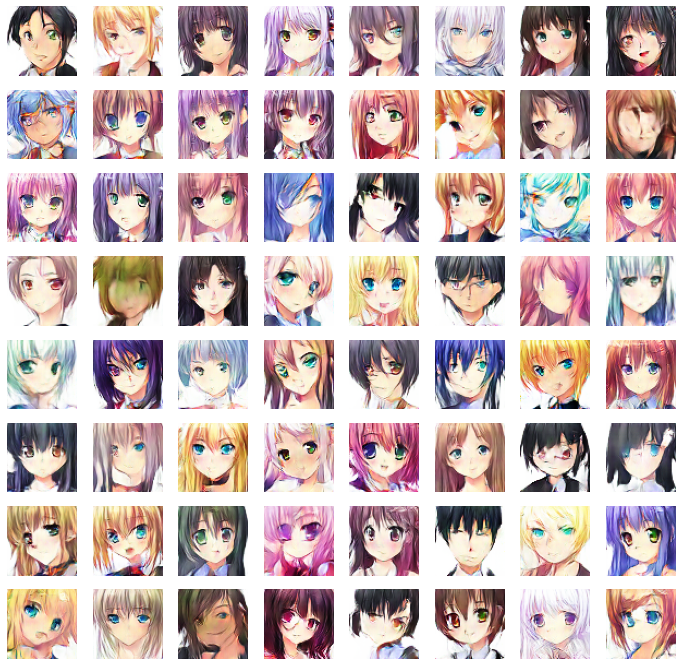

In [14]:
generate_faces()